In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import json
import random
import statistics
import numpy as np

from rtree import index
from utils import *

In [2]:
G = ox.save_load.load_graphml(filename="Paris_drive.graphml")
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

# get 100 sources
sources = nodes['osmid'].values[:100]
# get 100 targets
targets = nodes['osmid'].values[-100:]

In [3]:
# Fill in all nodes to find neighbours
# key: node label ,value: location
idx = index.Index()

xx = nodes['x'].astype(float)
yy = nodes['y'].astype(float)
node_id = nodes['osmid']

for node, x, y in zip(node_id, xx, yy):
    idx.insert(int(node), (x,y,x,y))

## Start

In [4]:
def bingo(sources, targets):
    
    h_time = []
    mh_time = [] # e_time same as mh_time
    h_query = []
    e_query = []
    mh_query = []
    
    count = 0
    for s,t in zip(sources,targets):
        orig_point = nodes[nodes['osmid'] == s].geometry.values[0]
        target_point = nodes[nodes['osmid'] == t].geometry.values[0]
        orig_xy = (orig_point.y, orig_point.x)
        target_xy = (target_point.y, target_point.x)

        # Find all nodes within 500m from candidate sources and destinations
        candidate_dest = find_nearest_nodes(nodes, target_xy, 450, idx)
        candidate_source = find_nearest_nodes(nodes, orig_xy, 450, idx)

        eq = len(candidate_dest) * len(candidate_source)
        e_query.append(eq)
#         print(eq)

        euclidean = get_length_dict(nodes, candidate_source, candidate_dest)  
        print("done here")
        (ht, hq, mht, mhq) = wrapper_all_search(nodes, euclidean)
        
        h_time.append(ht)
        h_query.append(hq)
        mh_time.append(mht)
        mh_query.append(mhq)
        
        count += 1
        print(count, s, t, hq, mhq, eq)

    return mh_query, mh_time, h_query, h_time, e_query

## Average-peak

In [5]:
mh_query_off, mh_time_off, h_query_off, h_time_off, e_query_off = bingo(sources, targets)

done here
1 5509971973 25034464 5562 2048 5562
done here
2 166297606 25034466 3007 1108 3007
done here
3 271450120 930283238 4620 1701 4620
done here
4 116129800 930283247 6308 2322 6308
done here
5 116129802 260800258 5200 1914 5200
done here
6 174981131 3756424973 4774 1758 4774
done here
7 116129804 15859474 5244 1931 5244
done here
8 268140568 175046421 4232 1558 4232
done here
9 141557799 15859479 3782 1393 3782
done here
10 6690897971 15859481 3060 1127 3060
done here
11 209158195 15859483 4740 1745 4740
done here
12 6180929592 15859484 6370 2345 6370
done here
13 6171131962 15859487 678 678 2470
done here
14 6194954302 4695326496 8010 2948 8010
done here
15 7228489799 2905112354 3168 1167 3168
done here
16 1854603337 260603683 3476 1280 3476
done here
17 245399630 260603684 4180 1539 4180
done here
18 94175315 260603682 6512 2397 6512
done here
19 5383094356 15859494 2475 912 2475
done here
20 5383094357 15859496 3332 1227 3332
done here
21 5383094362 15859497 3588 1321 3588
don

## Plot!

In [6]:
import matplotlib.pyplot as plt

# Average of: 
mht = statistics.mean(mh_time_off)
ht = statistics.mean(h_time_off)
eq = statistics.mean(e_query_off)
hq = statistics.mean(h_query_off)
mhq = statistics.mean(mh_query_off)

labels = ["Moderately-Peak"]
x = np.arange(len(labels))  # the label locations
width = 0.001  # the width of the bars

def autolabel(rects, ax, xpos='center'):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(math.ceil(height)),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # use 3 points offset
                    textcoords="offset points",  # in both directions
                    ha='center', va='bottom')

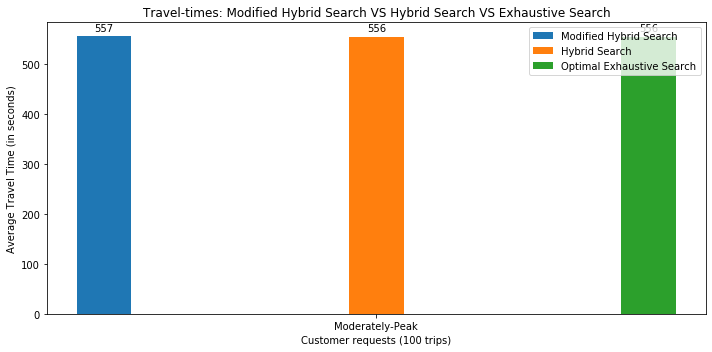

In [7]:
fig1, ax1 = plt.subplots(figsize=(10,5))
rects2 = ax1.bar(x - width, mht, width/5, label='Modified Hybrid Search')
rects1 = ax1.bar(x, ht, width/5, label='Hybrid Search')
rects6 = ax1.bar(x + width, ht, width/5, label='Optimal Exhaustive Search')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_ylabel('Average Travel Time (in seconds)')
ax1.set_xlabel('Customer requests (100 trips)')
ax1.set_title('Travel-times: Modified Hybrid Search VS Hybrid Search VS Exhaustive Search')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.legend()

autolabel(rects1, ax1)
autolabel(rects2, ax1)
autolabel(rects6, ax1)
fig1.tight_layout()

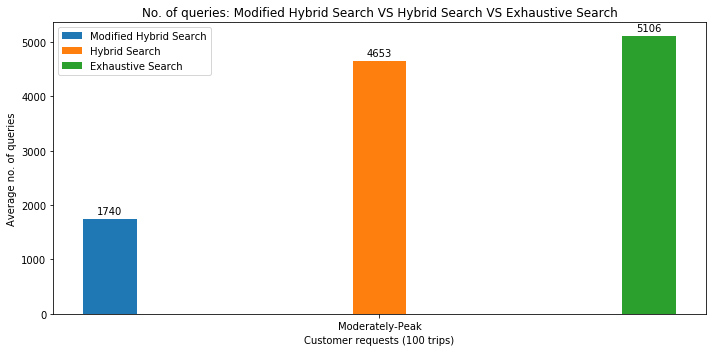

In [8]:
fig2, ax2 = plt.subplots(figsize=(10,5))
rects5 = ax2.bar(x - width, mhq, width/5, label='Modified Hybrid Search')
rects4 = ax2.bar(x, hq, width/5, label='Hybrid Search')
rects3 = ax2.bar(x + width, eq, width/5, label='Exhaustive Search')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_ylabel('Average no. of queries')
ax2.set_xlabel('Customer requests (100 trips)')
ax2.set_title('No. of queries: Modified Hybrid Search VS Hybrid Search VS Exhaustive Search')
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(loc='upper left')

autolabel(rects3, ax2)
autolabel(rects4, ax2)
autolabel(rects5, ax2)
fig2.tight_layout()